# Hand Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |



### Objectives of the Project:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [29]:
# Importing all the required packages
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [30]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [31]:
# Lets check whether the GPU is connected or not
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [32]:
train_doc = np.random.permutation(open('../input/gesture-recognition/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesture-recognition/val.csv').readlines())
batch_size = 64

In [33]:
## Checking the GPU configuration
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [34]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [35]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [36]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [37]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [38]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalizing images
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalizing images
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalizing images

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [39]:
# Creating a generator function
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [40]:
# Checking 
current_date_time = datetime.datetime.now()
train_path = '../input/gesture-recognition/train'
val_path = '../input/gesture-recognition/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [41]:
def getImgTensor(num_frames):
    img_idx = np.round(np.linspace(0, 29, num_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


### Generator Validation

In [42]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  ../input/gesture-recognition/train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  ../input/gesture-recognition/val ; batch size = 64
(64, 20, 100, 100, 3)


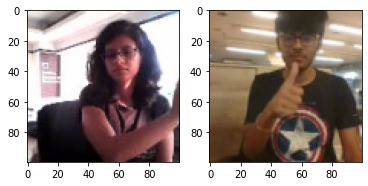

In [43]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[15,1,:,:,:])   
ax[1].imshow(sample_val_batch_data[26,10,:,:,:])
plt.show()

In [44]:
def plot_Model_History(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [45]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow import keras
import tensorflow as tf 

### Base Model

In [46]:
#writing our base model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 16, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 48, 48, 16)     64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 6, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 6, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 6, 23, 23, 32)     128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 4, 21, 21, 64)    

In [47]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model Callbacks Setup

In [49]:
model_name = 'Shashank_Rhea_Gesture_rec' + '' + str(current_date_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", min_delta = 1e-04, cooldown = 0,
  min_lr = 0)
# callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint, LR]

### Test Batch Size & Frames

In [50]:
def testBatchSize(batch_size, num_frames):
    img_tensor = getImgTensor(num_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# testBatchSize(batch_size=64, num_frames=30)

In [ ]:
# testBatchSize(batch_size=64, num_frames=16)

In [ ]:
# testBatchSize(batch_size=32, num_frames=30)

In [ ]:
# testBatchSize(batch_size=32, num_frames=16)

With above observations, we can see that batch size is not impacting training time but number of frames. We will use batch size of 64 as it seems optimal. It is commented as it takes a lot of time to run that is restricting for the notebook to completely run.

### Model 1 - Frames-15, Epoc-20

In [23]:
num_frames = 15
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_3 (Conv3D)            (None, 11, 96, 96, 16)    6016      

_________________________________________________________________

max_pooling3d_3 (MaxPooling3 (None, 6, 48, 48, 16)     0         

_________________________________________________________________

batch_normalization_5 (Batch (None, 6, 48, 48, 16)     64        

_________________________________________________________________

conv3d_4 (Conv3D)            (None, 4, 46, 46, 32)     13856     

_________________________________________________________________

max_pooling3d_4 (MaxPooling3 (None, 4, 23, 23, 32)     0         

_________________________________________________________________

batch_normalization_6 (Batch (None, 4, 23, 23, 32)     128       

_________________________________________________________________

conv3d_5 (Conv3D)            (None, 2, 21,

2022-09-16 11:28:45.169208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20

11/11 [==============================] - ETA: 0s - loss: 1.4939 - categorical_accuracy: 0.4510 Source path =  ../input/gesture-recognition/val ; batch size = 64

11/11 [==============================] - 181s 17s/step - loss: 1.4939 - categorical_accuracy: 0.4510 - val_loss: 10.2713 - val_categorical_accuracy: 0.2400



Epoch 00001: saving model to Shashank_Rhea_Gesture_rec2022-09-16112639.802654/model-00001-1.49389-0.45098-10.27132-0.24000.h5

Epoch 2/20

11/11 [==============================] - 53s 5s/step - loss: 1.0526 - categorical_accuracy: 0.5889 - val_loss: 10.6353 - val_categorical_accuracy: 0.2344



Epoch 00002: saving model to Shashank_Rhea_Gesture_rec2022-09-16112639.802654/model-00002-1.05262-0.58893-10.63526-0.23438.h5

Epoch 3/20

11/11 [==============================] - 52s 5s/step - loss: 1.0173 - categorical_accuracy: 0.5889 - val_loss: 8.1578 - val_categorical_accuracy: 0.2321



Epoch 00003: saving model to Shashank_Rhea_Gesture_rec2022-09-16112639.80265

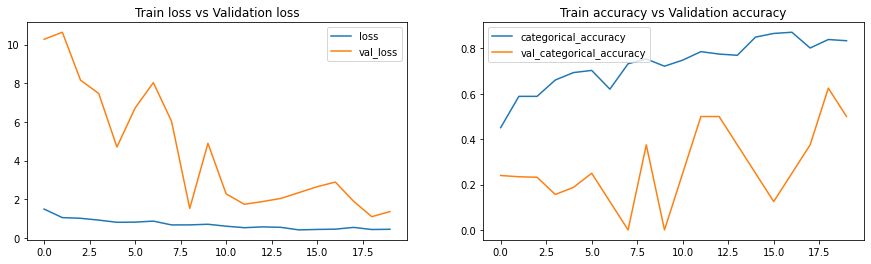

Max. Training Accuracy 0.8716577291488647

Max. Validaiton Accuracy 0.625


In [24]:
plot_Model_History(model1_history)

### Model 2: Frames-20, Epocs-30

In [25]:
num_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_6 (Conv3D)            (None, 16, 96, 96, 16)    6016      

_________________________________________________________________

max_pooling3d_6 (MaxPooling3 (None, 8, 48, 48, 16)     0         

_________________________________________________________________

batch_normalization_10 (Batc (None, 8, 48, 48, 16)     64        

_________________________________________________________________

conv3d_7 (Conv3D)            (None, 6, 46, 46, 32)     13856     

_________________________________________________________________

max_pooling3d_7 (MaxPooling3 (None, 6, 23, 23, 32)     0         

_________________________________________________________________

batch_normalization_11 (Batc (None, 6, 23, 23, 32)     128       

_________________________________________________________________

conv3d_8 (Conv3D)            (None, 4, 21,

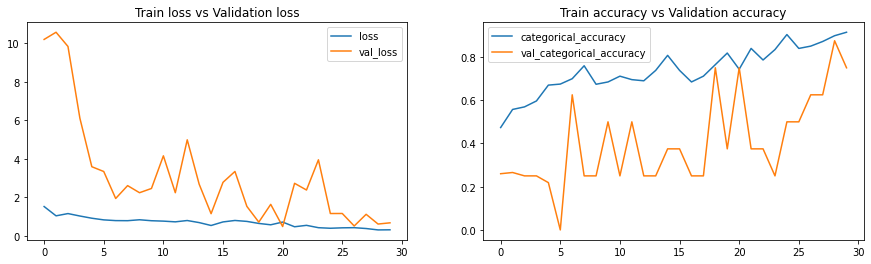

Max. Training Accuracy 0.9144384860992432

Max. Validaiton Accuracy 0.875


In [26]:
plot_Model_History(model2_history)

Reduce parameters, with padding in Conv3D layers and filter of (3,3,3).

### Model 3: Frames-30, Epocs-20, Interchanging num_frames and num_epochs

In [27]:
num_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size) # 663/64 = 11
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1 # 663//64

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size) # 100/64 = 2
else:
    validation_steps = (num_val_sequences//batch_size) + 1 # 100//64 = 2
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d3"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_9 (Conv3D)            (None, 30, 100, 100, 16)  1312      

_________________________________________________________________

max_pooling3d_9 (MaxPooling3 (None, 15, 50, 50, 16)    0         

_________________________________________________________________

batch_normalization_15 (Batc (None, 15, 50, 50, 16)    64        

_________________________________________________________________

conv3d_10 (Conv3D)           (None, 15, 50, 50, 32)    13856     

_________________________________________________________________

max_pooling3d_10 (MaxPooling (None, 8, 25, 25, 32)     0         

_________________________________________________________________

batch_normalization_16 (Batc (None, 8, 25, 25, 32)     128       

_________________________________________________________________

conv3d_11 (Conv3D)           (None, 8, 25,

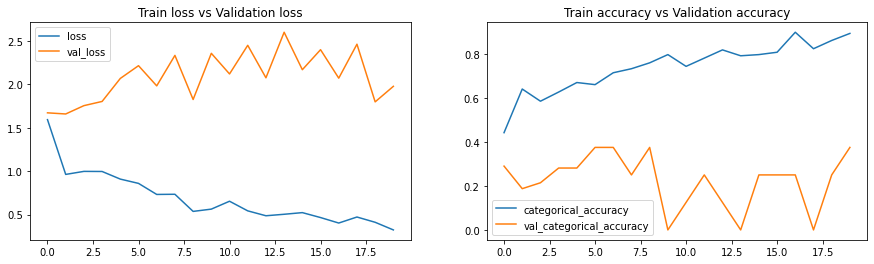

Max. Training Accuracy 0.8983957171440125

Max. Validaiton Accuracy 0.375


In [28]:
plot_Model_History(model3_history)

### Model 4: Frames-20, Batch_size = 32 Same pooling in Conv3D layer

In [29]:
num_frames = 20
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1 # 100//32 = 3

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_12 (Conv3D)           (None, 20, 100, 100, 16)  1312      

_________________________________________________________________

max_pooling3d_12 (MaxPooling (None, 10, 50, 50, 16)    0         

_________________________________________________________________

batch_normalization_20 (Batc (None, 10, 50, 50, 16)    64        

_________________________________________________________________

conv3d_13 (Conv3D)           (None, 10, 50, 50, 32)    13856     

_________________________________________________________________

max_pooling3d_13 (MaxPooling (None, 5, 25, 25, 32)     0         

_________________________________________________________________

batch_normalization_21 (Batc (None, 5, 25, 25, 32)     128       

_________________________________________________________________

conv3d_14 (Conv3D)           (None, 5, 25,

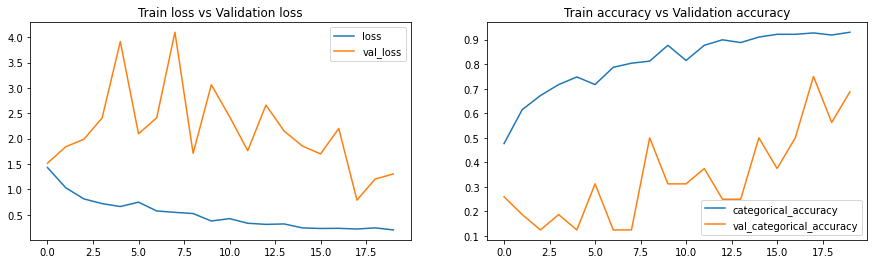

Max. Training Accuracy 0.9299719929695129

Max. Validaiton Accuracy 0.75


In [30]:
plot_Model_History(model4_history)

### Model 5: Frames:25, Epocs-25, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.

In [24]:
num_frames = 25
num_epochs = 25
batch_size = 64

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model5.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_3 (Conv3D)            (None, 25, 100, 100, 16)  400       

_________________________________________________________________

batch_normalization_5 (Batch (None, 25, 100, 100, 16)  64        

_________________________________________________________________

max_pooling3d_3 (MaxPooling3 (None, 12, 50, 50, 16)    0         

_________________________________________________________________

conv3d_4 (Conv3D)            (None, 12, 50, 50, 32)    4128      

_________________________________________________________________

batch_normalization_6 (Batch (None, 12, 50, 50, 32)    128       

_________________________________________________________________

max_pooling3d_4 (MaxPooling3 (None, 6, 25, 25, 32)     0         

_________________________________________________________________

conv3d_5 (Conv3D)            (None, 6, 25,

2022-09-16 14:00:08.336707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25

11/11 [==============================] - ETA: 0s - loss: 4.0513 - categorical_accuracy: 0.3318 Source path =  ../input/gesture-recognition/val ; batch size = 64

11/11 [==============================] - 318s 31s/step - loss: 4.0513 - categorical_accuracy: 0.3318 - val_loss: 1.5629 - val_categorical_accuracy: 0.3200



Epoch 00001: saving model to Shashank_Rhea_Gesture_rec2022-09-16135824.973915/model-00001-4.05127-0.33183-1.56287-0.32000.h5

Epoch 2/25

11/11 [==============================] - 99s 10s/step - loss: 1.1955 - categorical_accuracy: 0.5415 - val_loss: 1.6439 - val_categorical_accuracy: 0.3281



Epoch 00002: saving model to Shashank_Rhea_Gesture_rec2022-09-16135824.973915/model-00002-1.19554-0.54150-1.64392-0.32812.h5

Epoch 3/25

11/11 [==============================] - 97s 9s/step - loss: 0.9071 - categorical_accuracy: 0.6403 - val_loss: 3.4358 - val_categorical_accuracy: 0.1250



Epoch 00003: saving model to Shashank_Rhea_Gesture_rec2022-09-16135824.973915/m

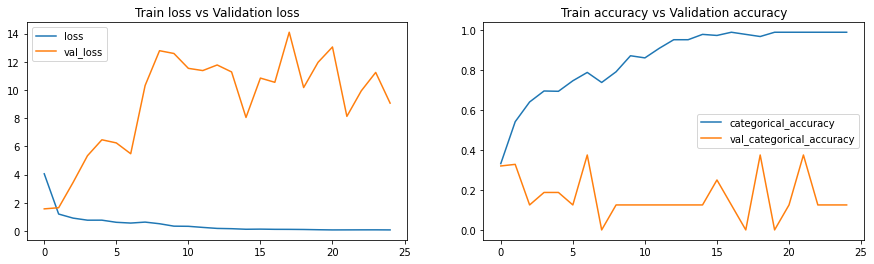

Max. Training Accuracy 0.9893048405647278

Max. Validaiton Accuracy 0.375


In [25]:
plot_Model_History(model5_history)

### Model 6: Switching Model Architecture into (RNN Based) Conv2D+LSTM

In [27]:
num_frames = 25
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


time_distributed_16 (TimeDis (None, 25, 100, 100, 16)  448       

_________________________________________________________________

time_distributed_17 (TimeDis (None, 25, 100, 100, 16)  64        

_________________________________________________________________

time_distributed_18 (TimeDis (None, 25, 50, 50, 16)    0         

_________________________________________________________________

time_distributed_19 (TimeDis (None, 25, 50, 50, 32)    4640      

_________________________________________________________________

time_distributed_20 (TimeDis (None, 25, 50, 50, 32)    128       

_________________________________________________________________

time_distributed_21 (TimeDis (None, 25, 25, 25, 32)    0         

_________________________________________________________________

time_distributed_22 (TimeDis (None, 25

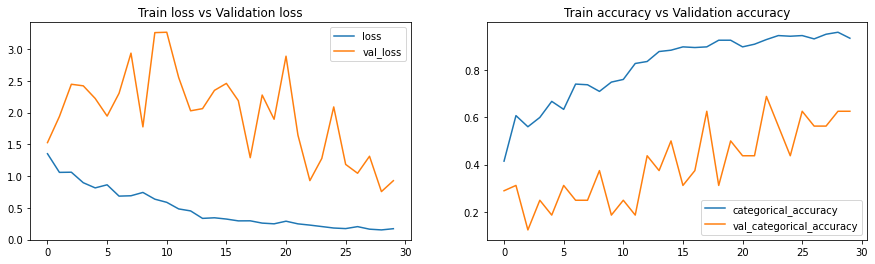

Max. Training Accuracy 0.9579831957817078

Max. Validaiton Accuracy 0.6875


In [28]:
plot_Model_History(model6_history)

### Model 7: Switching Model architecture to Conv2D+GRU

In [51]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

model7.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 25, 25, 64)   

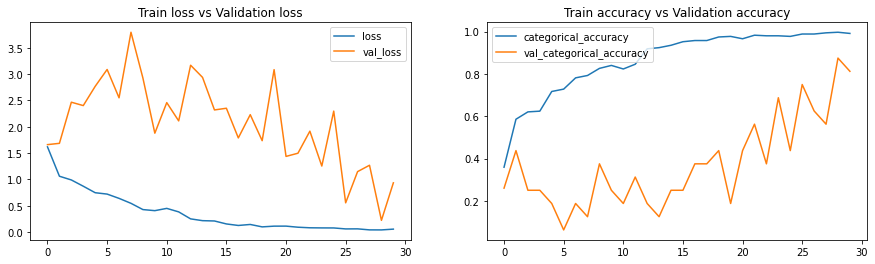

Max. Training Accuracy 0.9971988797187805
Max. Validaiton Accuracy 0.875


In [ ]:
plotModelHistory(model7_history)

### Model 8: Transfer Learning (MobileNet) with LSTM

In [29]:
from tensorflow.keras.applications import mobilenet

In [30]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

num_frames = 25
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(num_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model8 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model8.layers:
    layer.trainable = False

model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model8.add(TimeDistributed(Flatten()))

model8.add(LSTM(256))
model8.add(Dropout(0.2))

model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.2))

model8.add(Dense(5, activation='softmax'))

model8.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


17227776/17225924 [==============================] - 0s 0us/step

17235968/17225924 [==============================] - 0s 0us/step

Model: "mobilenet_lstm"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


time_distributed_32 (TimeDis (None, 25, 3, 3, 1024)    3228864   

_________________________________________________________________

time_distributed_33 (TimeDis (None, 25, 3, 3, 1024)    4096      

_________________________________________________________________

time_distributed_34 (TimeDis (None, 25, 1, 1, 1024)    0         

_________________________________________________________________

time_distributed_35 (TimeDis (None, 25, 1024)          0         

_________________________________________________________________

lstm_2 (LSTM)                (None, 256)               1311744   

_________________________________________________________________

dropout_6 (Dropout)          (None, 2

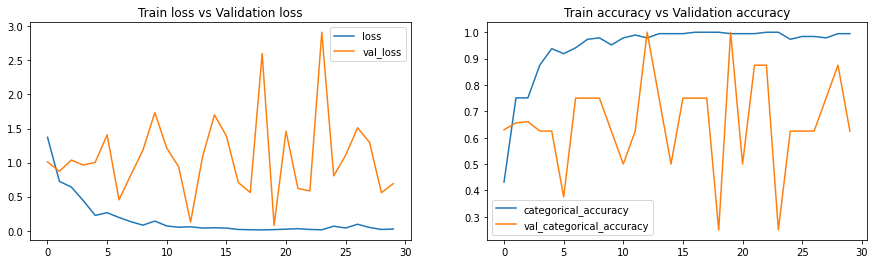

Max. Training Accuracy 1.0

Max. Validaiton Accuracy 1.0


In [31]:
plot_Model_History(model8_history)